In [40]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import string

import nlputils
from nlputils import SpacyPos

In [41]:
df = pd.read_csv('./../data/BBC/bbc_data.csv', index_col=0, sep=';')

In [42]:
df.head()

,title,description,image,keywords,synopses_small,synops_med,synops_long,category,channel,language,release_date,duration_sec,topic
id,,,,,,,,,,,,,
0,BBC Proms,Australian tenor Stuart Skelton is joined by L...,https://ichef.bbci.co.uk/images/ic/{recipe}/p0...,"BBC, iPlayer, TV, BBC Proms, 2021: Last Night ...",Australian tenor Stuart Skelton is joined by L...,Australian tenor Stuart Skelton is joined by L...,Katie Derham hosts continued live coverage fro...,Music,bbc_radio_three,False,9pm 11 Sep 2021,5247,music
1,Port,"Previously unseen music from the series Port, ...",https://ichef.bbci.co.uk/images/ic/{recipe}/p0...,"BBC, iPlayer, TV, Port, Series 5: Episode 4","Previously unseen music from the series Port, ...",Julie Fowlis a’ lìbhrigeadh ceòl bhon t-sreath...,Bidh Druthag Bheag Eile a’ tarraing ri chèile ...,Music,bbc_alba,False,9 Jul 2020,1037,music
2,"Sit Down, Stand Up with Greg James",Tom Holland and Greg James cold call celebrity...,https://ichef.bbci.co.uk/images/ic/{recipe}/p0...,"BBC, iPlayer, TV, Sit Down, Stand Up with Greg...",Tom Holland and Greg James cold call celebrity...,Tom Holland and Greg James cold call celebrity...,NaN,Entertainment,bbc_radio_one,False,10 Feb 2022,611,music
3,Ceiliúradh na Féile Pádraig,John Toal and Pauline Scanlon introduce an eve...,https://ichef.bbci.co.uk/images/ic/{recipe}/p0...,"BBC, iPlayer, TV, Ceiliúradh na Féile Pádraig",John Toal and Pauline Scanlon introduce an eve...,John Toal and Pauline Scanlon introduce an eve...,John Toal and Pauline Scanlon introduce an eve...,Music,bbc_two_northern_ireland_digital,False,17 Mar 2017,3538,music
4,Songs of Praise,Claire McCollum explores Edinburgh and shares ...,https://ichef.bbci.co.uk/images/ic/{recipe}/p0...,"BBC, iPlayer, TV, Songs of Praise, Edinburgh",Claire McCollum explores Edinburgh and shares ...,Claire McCollum goes on a Christian heritage t...,Claire McCollum explores Edinburgh and discove...,Music,bbc_one,False,1:15pm 20 Feb 2022,2044,music


In [43]:
print(len(df))
print(df['synops_long'].isnull().values.any())

3803
True


In [44]:
df_no_na = df.dropna()

In [45]:
print(len(df_no_na))
print(df_no_na['synops_long'].isnull().values.any())

3129
False


In [46]:
df_no_na['spacied_synops_long'] = nlputils.spacy_text(df_no_na['synops_long'])

  0%|          | 0/3129 [00:00<?, ?it/s]

/var/folders/2s/d47mm4m157l7p7yy3xrkwqsh0000gn/T/ipykernel_10196/2340832741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na['spacied_synops_long'] = nlputils.spacy_text(df_no_na['synops_long'])


In [47]:
pos_napv = [SpacyPos.NOUN, SpacyPos.ADJ, SpacyPos.PROPN, SpacyPos.VERB]
df_no_na['tokenized_synops_long'] = nlputils.pre_process(df_no_na['spacied_synops_long'], pos_napv)

/var/folders/2s/d47mm4m157l7p7yy3xrkwqsh0000gn/T/ipykernel_10196/188496553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na['tokenized_synops_long'] = nlputils.pre_process(df_no_na['spacied_synops_long'], pos_napv)


In [48]:
list_synopses = df_no_na['synops_long'].values.astype('U').tolist()

In [49]:
def preprocess(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [50]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess, lowercase=True, stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(list_synopses)

kmeans = KMeans(n_clusters=3).fit(tfidf)

In [54]:
sentences_to_predict = ["I am a young person looking for an apartment in San Francisco", "I really like the old vibes and of Miami"]
kmeans.predict(tfidf_vectorizer.transform(sentences_to_predict))

array([0, 0], dtype=int32)

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot(user_ratings, k):

        h = 0.2
        reduced_data = PCA(n_components=2).fit_transform(user_ratings)

        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit(reduced_data)

        x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
        y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)

        plt.figure(1)
        plt.clf()
        plt.imshow(Z, interpolation='nearest',
                   extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                   cmap=plt.cm.Paired,
                   aspect='auto', origin='lower')

        centroids = kmeans.cluster_centers_
        plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x', s=169, linewidths=3,
                    color='r', zorder=10)
        plt.title('K-means clustering of the user')

/Users/hagenaadfock/miniforge3/envs/default/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


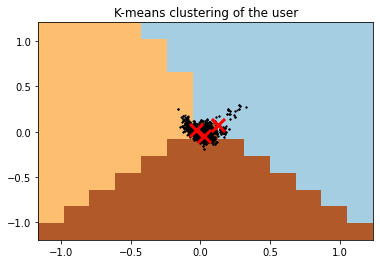

In [53]:
from scipy.sparse import dok_matrix

d_matrix = dok_matrix(tfidf).todense()

plot(user_ratings=d_matrix, k=3)